<a href="https://colab.research.google.com/github/lexoz-bedra/spam_classification_vk/blob/main/vk_spam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv("/content/drive/My Drive/vk/spam/train_spam.csv")
test = pd.read_csv("/content/drive/My Drive/vk/spam/test_spam.csv")

# EDA & Preprocessing

In [4]:
train.head(3)

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...


In [5]:
train.shape

(16278, 2)

In [6]:
test.head(3)

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...


In [7]:
test.shape

(4070, 1)

Посмотрим на распределение спама и не спама среди сообщений и попробуем выявить, как визуально отличается текст одного класса от другого.

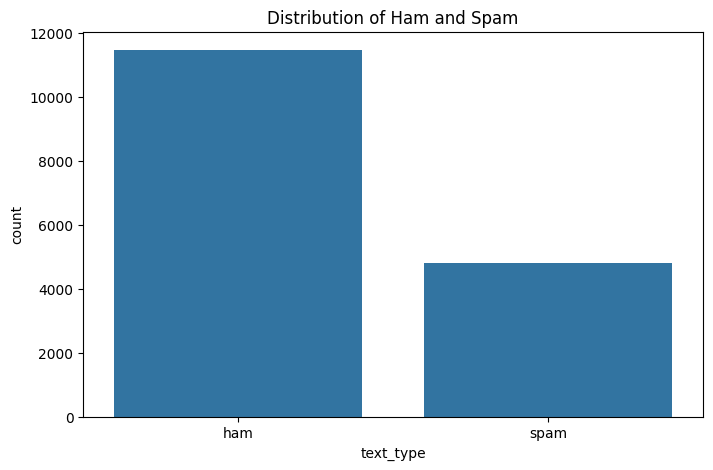

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='text_type')
plt.title('Distribution of Ham and Spam')

plt.show()

Спама в датасете значительно меньше.

Сделаем label encoding для таргета.

In [9]:
enc = LabelEncoder()

train['text_type'] = enc.fit_transform(train['text_type'].astype(str))

In [10]:
train.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...




Первым делом при решении этой задачи мне видится очень наивный метод её решения - составить словари для спама и неспама и с помощью какого-нибудь классификатора (например, наивного байесовского - можно взять любой другой, но наивный байес был выбран из-за скорости обучения) с помощью этих словарей разбить письма на два класса. Для этого потребуется векторизатор, в качестве которого возьмём TF-IDF и CountVectorizer и сравним. Можно использовать и более сложные модели для векторизации, такие как Word2Vec или BERT. Протестируем классификатор также с Word2Vec.

Возможно, лучшим решением будет написать собственный классификатор (я думаю о нейронных сетях), а в качестве векторизатора использовать тот, который даст самые лучшие результаты с наивным Байесом.


Сравним эти подходы и посмотрим, какой из них лучше отработает.

# Naive Bayes

## CountVectorizer

Посмотрим, какие слова чаще встречаются в спаме, а какие нет.

Для этого создадим сет из слов для спама и для не спама, затем обработаем значения в нём: удалим стоп-слова, сделаем стемминг (так как у нас данные на английском, будем использовать именно стемминг, потому что он быстрее и для английского работает достаточно хорошо).

In [11]:
nltk.download('punkt')
nltk.download('stopwords')

stemmer = SnowballStemmer('english')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def preprocess_text(text):
    words = word_tokenize(str(text).lower())
    words = [word for word in words if word not in stop_words]
    words = [stemmer.stem(word) for word in words]
    return words

In [13]:
spam_words = Counter()
ham_words = Counter()

In [14]:
for _, row in train.iterrows():
    words = preprocess_text(row['text'])
    if row['text_type'] == 1:
        spam_words.update(words)
    elif row['text_type'] == 0:
        ham_words.update(words)

In [15]:
print("Most common words in spam:", spam_words.most_common(10))
print("Most common words in ham:", ham_words.most_common(10))

Most common words in spam: [('1635465', 1568), ('free', 1059), ('get', 954), ('$', 759), ('@', 736), ('1', 690), ('!', 640), ('invest', 637), ('call', 600), ('receiv', 595)]
Most common words in ham: [('1635465', 11000), ('ect', 5344), ('enron', 4850), ('vinc', 4530), ('url', 3625), ('hou', 2660), ('kaminski', 2382), ('2000', 2204), ('subject', 2117), ('pleas', 1948)]


Далее удалим слова, которые встречаются и там, и там.

In [16]:
mutual_words = set(spam_words).intersection(set(ham_words))

for word in mutual_words:
    del spam_words[word]
    del ham_words[word]

In [17]:
print("Most common unique words in spam:", spam_words.most_common(10))
print("Most common unique words in ham:", ham_words.most_common(10))

Most common unique words in spam: [('𝑰', 149), ('𝒕𝒐', 137), ('𝐈', 131), ('ɪ', 114), ('𝐭𝐨', 111), ('𝒎𝒚', 108), ('𝒂𝒏𝒅', 108), ('🔥', 108), ('ᴛᴏ', 103), ('𝒚𝒐𝒖', 93)]
Most common unique words in ham: [('enron', 4850), ('kaminski', 2382), ('stinson', 565), ('crenshaw', 556), ('rpm', 456), ('713', 328), ('gibner', 325), ('rice', 312), ('zimin', 282), ('1635465t1635465', 264)]


Можно сразу заметить, что в спаме часто используются необычные шрифты, эмодзи. Сюда же относится много восклицательных знаков (этого, конечно, здесь не видно, потому что восклицательный знак мы из множества, скорее всего, удалили, но это было видно до удаления пересечения).

После составления словарей можно начать строить и обучать наивный байесовский классификатор.

In [18]:
vocabulary = list(set(spam_words.elements()) | set(ham_words.elements()))

vectorizer = CountVectorizer(vocabulary=vocabulary)

In [19]:
X = train['text']
y = train['text_type']

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [21]:
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)

naive_bayes_count = MultinomialNB()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:1380: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(


In [22]:
naive_bayes_count.fit(X_train, y_train)

MultinomialNB()

In [23]:
y_pred_proba = naive_bayes_count.predict_proba(X_val)[:, 1]

In [24]:
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.8543791054473571


## TF-IDF

Здесь всё попроще и покороче, нам не нужно делать словарь.

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=42)

In [26]:
vectorizer = TfidfVectorizer()
classifier = MultinomialNB()

In [27]:
naive_bayes_tfidf = make_pipeline(vectorizer, classifier)

In [28]:
naive_bayes_tfidf.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('multinomialnb', MultinomialNB())])

In [29]:
y_pred_proba = naive_bayes_tfidf.predict_proba(X_val)[:, 1]

In [30]:
roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9365253774534763


Значение метрики очень приличное, если использовать оба этих способа, но во втором случае (если в качестве векторизатора использовать TF-IDF) намного лучше.


## Word2Vec

In [31]:
def get_text_vector(text, model):
    text_vec = [model.wv[word] for word in preprocess_text(text) if word in model.wv]
    if text_vec:
        return np.mean(text_vec, axis=0)
    else:
        return np.zeros(model.vector_size)

In [32]:
texts_tokenized = [preprocess_text(text) for text in train['text']]

In [33]:
word2vec = Word2Vec(sentences=texts_tokenized, vector_size=100, window=5, min_count=1, workers=4)

In [34]:
X = np.array([get_text_vector(text, word2vec) for text in train['text']])
y = np.array(train['text_type'])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
classifier = GaussianNB()

In [36]:
classifier.fit(X_train, y_train)

GaussianNB()

In [37]:
y_pred_proba = classifier.predict_proba(X_val)[:, 1]

In [38]:
roc_auc = roc_auc_score(y_val, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.860546694099676


В качестве векторизатора лучше всего показал себя TF-IDF. Будем использовать его в модели с кастомным классификатором.

# Custom Classifier (NN)

In [39]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(train['text']).toarray()

In [40]:
class CustomTensorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.long)
        return x, y

    def __len__(self):
        return len(self.labels)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = CustomTensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = CustomTensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32)

In [42]:
class SpamClassifier(nn.Module):
    def __init__(self, num_features):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.log_softmax(self.fc2(x), dim=1)
        return x

In [43]:
model = SpamClassifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [44]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [45]:
y_true = []
y_pred_probs = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        probabilities = softmax(outputs, dim=1)[:, 1]
        y_true.extend(labels.numpy())
        y_pred_probs.extend(probabilities.numpy())

In [46]:
roc_auc = roc_auc_score(y_true, y_pred_probs)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9844726249749439


Нейросеть в комбинации с TF-IDF показала очень хорошие результаты. Применим её для предсказаний на тестовом датасете.

# Scoring on Test Dataset

In [47]:
class CustomTestTensorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        x = torch.tensor(self.data[index], dtype=torch.float32)
        return x

    def __len__(self):
        return len(self.data)

In [48]:
X_test = tfidf.transform(test['text']).toarray()

In [49]:
test_dataset = CustomTestTensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [50]:
test_probabilities = []

model.eval()
with torch.no_grad():
    for inputs in test_loader:
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)[:, 1].numpy()
        test_probabilities.extend(probabilities)

In [51]:
results_df = pd.DataFrame({'text': test['text'], 'score': test_probabilities})

In [52]:
results_df.to_csv('test_scores.csv', index=False)